1 赛题介绍
《绝地求生》(PUBG) 是一款战术竞技型射击类沙盒游戏。在该游戏中，玩家需要在游戏地图上收集各种资源，并在不断缩小的安全区域内对抗其他玩家，让自己生存到最后。当选手在本局游戏中取得第一名后，会有一段台词出现：“大吉大利，晚上吃鸡!”。

在本次赛题中，我们收集了PUBG比赛数据中玩家的行为数据，希望选手能够构建模型对玩家每局最终的排名进行预测。

2 赛事任务
构建吃鸡排名预测模型，输入每位玩家的统计信息、队友统计信息、本局其他玩家的统计信息，预测最终的游戏排名。这里的排名是按照队伍排名，若多位玩家在PUBG一局游戏中组队，则最终排名相同。

赛题训练集案例如下： 训练集5万局数据，共150w行 测试集共5000局条数据，共50w行

赛题数据文件总大小150MB，数据均为csv格式，列使用逗号分割。若使用Pandas读取数据，可参考如下代码：

In [218]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置负号'-'的显示，避免保存图像时显示为方块
plt.rcParams['axes.unicode_minus'] = False

测试集中label字段team_placement为空，需要选手预测。完整的数据字段含义如下：

match_id：本局游戏的id
team_id：本局游戏中队伍id，表示在每局游戏中队伍信息
game_size：本局队伍数量
party_size：本局游戏中队伍人数
player_assists：玩家助攻数
player_dbno：玩家击倒数
player_dist_ride：玩家车辆行驶距离
player_dist_walk：玩家不幸距离
player_dmg：输出伤害值
player_kills：玩家击杀数
player_name：玩家名称，在训练集和测试集中全局唯一
kill_distance_x_min：击杀另一位选手时最小的x坐标间隔
kill_distance_x_max：击杀另一位选手时最大的x坐标间隔
kill_distance_y_min：击杀另一位选手时最小的y坐标间隔
kill_distance_y_max：击杀另一位选手时最大的x坐标间隔
team_placement：队伍排名
选手需要提交测试集队伍排名预测，具体的提交格式如下：

team_placement
19
19
37
37
49
49
13
13

3 评估指标
本次竞赛的使用绝对回归误差MAE进行评分，数值越低精度越高，评估代码参考：

4 数据分析
结合已有的赛题信息，接下来我们将深入分析数据内部的规律，找出什么类型的队伍会取得更好的排名？

赛题字段分析
赛题标签分析
字段相关性分析

In [219]:
import pandas as pd

%pylab inline
import seaborn as sns

train_df = pd.read_csv('data/pubg_train.csv')
test_df = pd.read_csv('data/pubg_test.csv')
train_df.info()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   match_id             1500000 non-null  int64  
 1   team_id              1500000 non-null  int64  
 2   game_size            1500000 non-null  int64  
 3   party_size           1500000 non-null  int64  
 4   player_assists       1500000 non-null  int64  
 5   player_dbno          1500000 non-null  int64  
 6   player_dist_ride     1500000 non-null  float64
 7   player_dist_walk     1500000 non-null  float64
 8   player_dmg           1500000 non-null  int64  
 9   player_kills         1500000 non-null  int64  
 10  player_name          1500000 non-null  int64  
 11  kill_distance_x_min  635716 non-null   float64
 12  kill_distan

In [220]:
# 查看训练集 验证集
train_df.shape, test_df.shape

((1500000, 16), (500000, 15))

In [221]:
# 创建特征 击杀最小距离和最大距离
try:
    train_df['kill_distance_z_min'] = np.sqrt(
        train_df['kill_distance_x_min'] ** 2 + train_df['kill_distance_y_min'] ** 2)
    train_df['kill_distance_z_max'] = np.sqrt(
        train_df['kill_distance_x_max'] ** 2 + train_df['kill_distance_y_max'] ** 2)
    train_df['kill_means_dmg'] = np.where(train_df['player_kills'] == 0, 0,
                                          train_df['player_dmg'] / train_df['player_kills'])
    train_df['player_dist_sum'] = train_df['player_dist_ride'] + train_df['player_dist_walk']
    train_df['player_count'] = train_df['game_size'] * train_df['party_size']
except Exception as e:
    print(f"An error occurred: {e}")


In [222]:
train_df.head(5)

,match_id,team_id,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,...,kill_distance_x_min,kill_distance_x_max,kill_distance_y_min,kill_distance_y_max,team_placement,kill_distance_z_min,kill_distance_z_max,kill_means_dmg,player_dist_sum,player_count
0,0,1,50,2,0,1,4984.54900,2054.031490,218,2,...,1689.9,3992.9,137.0,819.8,5,1695.444193,4076.189697,109.0,7038.580490,100
1,0,1,50,2,1,0,5960.46436,2268.221000,125,0,...,NaN,NaN,NaN,NaN,5,NaN,NaN,0.0,8228.685360,100
2,0,2,50,2,0,0,0.00000,0.000000,0,0,...,NaN,NaN,NaN,NaN,49,NaN,NaN,0.0,0.000000,100
3,0,2,50,2,0,0,0.00000,5.211829,41,0,...,NaN,NaN,NaN,NaN,49,NaN,NaN,0.0,5.211829,100
4,0,3,50,2,0,0,0.00000,341.730927,69,0,...,NaN,NaN,NaN,NaN,34,NaN,NaN,0.0,341.730927,100


<Axes: >

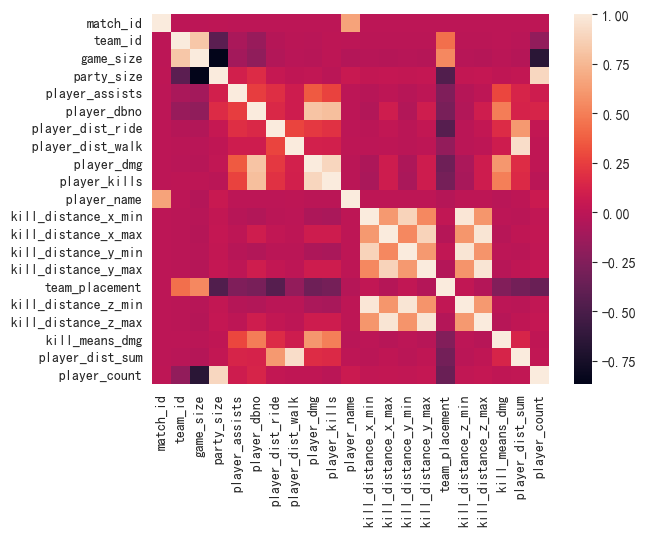

In [223]:
# 热力图查看数据关联性
sns.heatmap(train_df.corr())

In [224]:
train_df.columns

Index(['match_id', 'team_id', 'game_size', 'party_size', 'player_assists',
       'player_dbno', 'player_dist_ride', 'player_dist_walk', 'player_dmg',
       'player_kills', 'player_name', 'kill_distance_x_min',
       'kill_distance_x_max', 'kill_distance_y_min', 'kill_distance_y_max',
       'team_placement', 'kill_distance_z_min', 'kill_distance_z_max',
       'kill_means_dmg', 'player_dist_sum', 'player_count'],
      dtype='object')

    5 模型训练与验证
数据处理

In [225]:

train_df = train_df.drop(['match_id', 'team_id'], axis=1)
test_df = test_df.drop(['match_id', 'team_id'], axis=1)
# 填充nan值，避免训练出错
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
train_df.columns

Index(['game_size', 'party_size', 'player_assists', 'player_dbno',
       'player_dist_ride', 'player_dist_walk', 'player_dmg', 'player_kills',
       'player_name', 'kill_distance_x_min', 'kill_distance_x_max',
       'kill_distance_y_min', 'kill_distance_y_max', 'team_placement',
       'kill_distance_z_min', 'kill_distance_z_max', 'kill_means_dmg',
       'player_dist_sum', 'player_count'],
      dtype='object')

In [226]:
# 标签归一化，按照本场比赛的队伍数量进行处理
# train_df['team_placement'] /= train_df['game_size'] 
column = ['game_size', 'party_size', 'player_assists', 'player_dbno',
 'player_dist_ride', 'player_dist_walk', 'player_dmg', 'player_kills',
 'player_name', 'kill_distance_x_min', 'kill_distance_x_max',
 'kill_distance_y_min', 'kill_distance_y_max',
 'kill_distance_z_min', 'kill_distance_z_max', 'kill_means_dmg',
 'player_dist_sum', 'player_count', 'team_placement']
train_df = train_df[column]
# 数值归一化 将每一列数据除以最大值
for col in train_df.columns[:-1]:
    print(col)
    train_df[col] /= train_df[col].max()
    # test_df[col] /= test_df[col].max()

game_size
party_size
player_assists
player_dbno
player_dist_ride
player_dist_walk
player_dmg
player_kills
player_name
kill_distance_x_min
kill_distance_x_max
kill_distance_y_min
kill_distance_y_max
kill_distance_z_min
kill_distance_z_max
kill_means_dmg
player_dist_sum
player_count


模型搭建

In [227]:
class Regressor(torch.nn.Module):
    # self代表类的实例自身
    def __init__(self):
        super(Regressor, self).__init__()

        # 网络参数（调整此处获得不同模型）
        self.fc1 = torch.nn.Linear(18, 128)
        self.relu = torch.nn.ReLU()  # 使用 ReLU 激活函数
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 32)
        self.fc4 = torch.nn.Linear(32, 1)  # 输出层

    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.relu(x)  # 隐藏层使用 ReLU
        x = self.fc2(x)
        x = self.relu(x)  # 隐藏层使用 ReLU
        x = self.fc3(x)
        x = self.relu(x)  # 隐藏层使用 ReLU
        x = self.fc4(x)  # 输出层

        return x

In [228]:
# 声明定义好的线性回归模型 实例化
model = Regressor()

# 开启模型训练模式
model.train()

# 定义优化算法，使用随机梯度下降SGD
opt = torch.optim.Adam(model.parameters(), lr=0.001)

模型训练

In [229]:
EPOCH_NUM = 100  # 设置外层循环次数 尽量大
BATCH_SIZE = 1500  # 设置batch大小  根据硬件调整
# 优化算法
training_data = train_df.iloc[:-10000].values.astype(np.float32)
val_data = train_df.iloc[-10000:].values.astype(np.float32)
# 记录 MAE 结果的列表
train_mae_list = []
val_mae_list = []
# 定义外层循环
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)

    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k + BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]

    train_loss = []
    for iter_id, mini_batch in enumerate(mini_batches):
        # 清空梯度变量，以备下一轮计算
        opt.zero_grad()

        x = np.array(mini_batch[:, :-1])
        y = np.array(mini_batch[:, -1:])

        # 将numpy数据转为飞桨动态图tensor的格式
        features = torch.tensor(x)
        y = torch.tensor(y)

        # 前向计算
        predicts = model(features)

        # 计算损失

        loss = torch.nn.functional.l1_loss(predicts, y)
        avg_loss = torch.mean(loss)

        train_loss.append(avg_loss.detach().numpy())

        # 反向传播，计算每层参数的梯度值
        avg_loss.backward()

        # 更新参数，根据设置好的学习率迭代一步
        opt.step()

    mini_batches = [val_data[k:k + BATCH_SIZE] for k in range(0, len(val_data), BATCH_SIZE)]
    val_loss = []
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1])
        y = np.array(mini_batch[:, -1:])

        features = torch.tensor(x)
        y = torch.tensor(y)

        predicts = model(features)
        loss = torch.nn.functional.l1_loss(predicts, y)
        avg_loss = torch.mean(loss)
        val_loss.append(avg_loss.detach().numpy())

    # 记录每个 epoch 的 MAE
    train_mae_list.append(np.mean(train_loss))
    val_mae_list.append(np.mean(val_loss))
    print(f'Epoch {epoch_id}, train MAE {np.mean(train_loss)}, val MAE {np.mean(val_loss)}')

Epoch 0, train MAE 9.960970878601074, val MAE 6.670741081237793
Epoch 1, train MAE 5.780174732208252, val MAE 5.22678804397583
Epoch 2, train MAE 4.973081111907959, val MAE 4.769153118133545
Epoch 3, train MAE 4.838193416595459, val MAE 4.727025032043457
Epoch 4, train MAE 4.782989978790283, val MAE 4.6821112632751465
Epoch 5, train MAE 4.754961967468262, val MAE 4.6624369621276855
Epoch 6, train MAE 4.730250358581543, val MAE 4.950608730316162
Epoch 7, train MAE 4.716092586517334, val MAE 4.8062663078308105
Epoch 8, train MAE 4.7043070793151855, val MAE 4.617084980010986
Epoch 9, train MAE 4.697287559509277, val MAE 4.595192909240723
Epoch 10, train MAE 4.684972286224365, val MAE 4.637165546417236
Epoch 11, train MAE 4.681085586547852, val MAE 4.68301248550415
Epoch 12, train MAE 4.668356895446777, val MAE 4.6531243324279785
Epoch 13, train MAE 4.675278186798096, val MAE 4.623356819152832
Epoch 14, train MAE 4.677299499511719, val MAE 4.611645698547363
Epoch 15, train MAE 4.6673789024

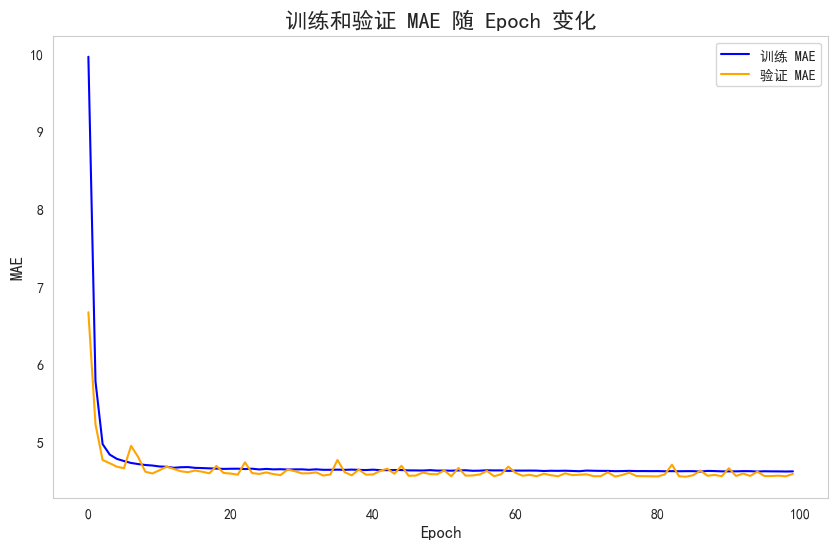

In [230]:
# 可视化 MAE 变化
plt.figure(figsize=(10, 6))
plt.plot(train_mae_list, label='训练 MAE', color='blue')
plt.plot(val_mae_list, label='验证 MAE', color='orange')

plt.title('训练和验证 MAE 随 Epoch 变化', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.grid()
plt.legend()
plt.show()

In [231]:
train_loss.append(avg_loss.detach().numpy())

In [232]:
model.eval()
test_data = torch.tensor(test_df.values.astype(np.float32))
test_predict = model(test_data)
test_predict = test_predict.detach().numpy().flatten()
test_predict = test_predict.round().astype(int)
len(test_predict)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (500000x13 and 18x128)

In [76]:
# pd.DataFrame({'team_placement': test_predict}).to_csv('data/submission.csv', index=None)

# 在左侧刷新下载到桌面后提交进行评测即可

6 总结与展望
项目使用全连接网络进行训练和预测。

后续改进方法有：

按照队伍进行聚合统计数据，构造新特征。
将标签归一化到0-1之间，进行训练。